# COGS 118A - Final Project

# Flight Price Predictor

## Group members

- Drake Coy
- Aditi Krishnakumar
- Simran Nayyer
- Jasmine Qiang
- Luke Sztajnkrycer

# Abstract 
This section should be short and clearly stated. It should be a single paragraph <200 words.  It should summarize: 
- what your goal/problem is
- what the data used represents 
- the solution/what you did
- major results you came up with (mention how results are measured) 

__NB:__ this final project form is much more report-like than the proposal and the checkpoint. Think in terms of writing a paper with bits of code in the middle to make the plots/tables

# Background

Fill in the background and discuss the kind of prior work that has gone on in this research area here. **Use inline citation** to specify which references support which statements.  You can do that through HTML footnotes (demonstrated here). I used to reccommend Markdown footnotes (google is your friend) because they are simpler but recently I have had some problems with them working for me whereas HTML ones always work so far. So use the method that works for you, but do use inline citations.

Here is an example of inline citation. After government genocide in the 20th century, real birds were replaced with surveillance drones designed to look just like birds<a name="lorenz"></a>[<sup>[1]</sup>](#lorenznote). Use a minimum of 2 or 3 citations, but we prefer more <a name="admonish"></a>[<sup>[2]</sup>](#admonishnote). You need enough citations to fully explain and back up important facts. 

Remeber you are trying to explain why someone would want to answer your question or why your hypothesis is in the form that you've stated. 

# Problem Statement

Clearly describe the problem that you are solving. Avoid ambiguous words. The problem described should be well defined and should have at least one ML-relevant potential solution. Additionally, describe the problem thoroughly such that it is clear that the problem is quantifiable (the problem can be expressed in mathematical or logical terms), measurable (the problem can be measured by some metric and clearly observed), and replicable (the problem can be reproduced and occurs more than once).

# Data

Detail how/where you obtained the data and cleaned it (if necessary)

If the data cleaning process is very long (e.g., elaborate text processing) consider describing it briefly here in text, and moving the actual clearning process to another notebook in your repo (include a link here!).  The idea behind this approach: this is a report, and if you blow up the flow of the report to include a lot of code it makes it hard to read.

Please give the following infomration for each dataset you are using
- link/reference to obtain it
- description of the size of the dataset (# of variables, # of observations)
- what an observation consists of
- what some critical variables are, how they are represented
- any special handling, transformations, cleaning, etc you have done should be demonstrated here!


# Proposed Solution

In this section, clearly describe a solution to the problem. The solution should be applicable to the project domain and appropriate for the dataset(s) or input(s) given. Provide enough detail (e.g., algorithmic description and/or theoretical properties) to convince us that your solution is applicable. Make sure to describe how the solution will be tested.  

If you know details already, describe how (e.g., library used, function calls) you plan to implement the solution in a way that is reproducible.

If it is appropriate to the problem statement, describe a benchmark model<a name="sota"></a>[<sup>[3]</sup>](#sotanote) against which your solution will be compared. 

# Evaluation Metrics

Propose at least one evaluation metric that can be used to quantify the performance of both the benchmark model and the solution model. The evaluation metric(s) you propose should be appropriate given the context of the data, the problem statement, and the intended solution. Describe how the evaluation metric(s) are derived and provide an example of their mathematical representations (if applicable). Complex evaluation metrics should be clearly defined and quantifiable (can be expressed in mathematical or logical terms).

# Results

You may have done tons of work on this. Not all of it belongs here. 

Reports should have a __narrative__. Once you've looked through all your results over the quarter, decide on one main point and 2-4 secondary points you want us to understand. Include the detailed code and analysis results of those points only; you should spend more time/code/plots on your main point than the others.

If you went down any blind alleys that you later decided to not pursue, please don't abuse the TAs time by throwing in 81 lines of code and 4 plots related to something you actually abandoned.  Consider deleting things that are not important to your narrative.  If its slightly relevant to the narrative or you just want us to know you tried something, you could keep it in by summarizing the result in this report in a sentence or two, moving the actual analysis to another file in your repo, and providing us a link to that file.

### Subsection 1

You will likely have different subsections as you go through your report. For instance you might start with an analysis of the dataset/problem and from there you might be able to draw out the kinds of algorithms that are / aren't appropriate to tackle the solution.  Or something else completely if this isn't the way your project works.

### Subsection 2

Another likely section is if you are doing any feature selection through cross-validation or hand-design/validation of features/transformations of the data

### Subsection 3

Probably you need to describe the base model and demonstrate its performance.  Maybe you include a learning curve to show whether you have enough data to do train/validate/test split or have to go to k-folds or LOOCV or ???

### Subsection 4

Perhaps some exploration of the model selection (hyper-parameters) or algorithm selection task. Validation curves, plots showing the variability of perfromance across folds of the cross-validation, etc. If you're doing one, the outcome of the null hypothesis test or parsimony principle check to show how you are selecting the best model.

### Subsection 5 

Maybe you do model selection again, but using a different kind of metric than before?



## Decision Tree Exploration

### Basic Tree

The next model we explored was the DecisionTree and its variations. Since the purpose of our project is to find out what factors impact flight price the most, the decision tree makes intuitive sense to be used in our analysis because it will tell us exactly what decisions lead to each price. 

We first established a "baseline" tree to see how our tree would look with the default hyperparameters. 

In [ ]:
from sklearn.model_selection import cross_val_score, RepeatedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree
from sklearn.tree import export_text
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
X = extra_trees_data.drop('price', axis=1)
y = extra_trees_data['price']

feature_names = X.columns
labels = ["".join(item) for item in y.unique().astype(str)]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [ ]:
dTree = DecisionTreeClassifier(max_depth = None, random_state = 42)
dTree.fit(X_train, y_train)
y_pred_dTree = dTree.predict(X_test)

In [ ]:
print(dTree.get_depth())

Without changing any of the parameters, our baseline tree achieves a depth of 40. Unfortunately plotting this tree takes quite a while and so we were unable to get a plotted tree but we did get a text version of it and it saved under our repository: LINK

Unlike with the LinearRegression, with the DecisionTree we are actually able to see which factors were the most impactful in classifying price. The "class" feature was the first split followed by "destination city" and "source city" as the next two. Just from this baseline model we were able to gain insight on which factors are most influential - something which was not possible with the LinearRegression.

The training accuracy of this classifier is very high, but the testing accuracy is much lower which could indicate that the model does not generalize well. To combat this, our next step was to tune the hyperparameters while accounting for overfitting and we will do so with a GridSearch.

In [ ]:
param = {
    "max_depth": [10,40,60],
    "min_samples_split":[20,40,60,80],
    "min_impurity_decrease": [0.0001, 0.001, 0.01]
}

grid = GridSearchCV(DecisionTreeClassifier(random_state = 42), param_grid = param, cv = 10, verbose = 1, n_jobs = -1)
grid.fit(X_train, y_train)

In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

After doing some research we decided to vary the tree parameters max_depth, min_samples_split, and min_impurity_decrease. We tried many ranges and combinations of these parameters and although this manual search was not exhaustive, we were able to narrow it down to one set of parameters that got the best accuracy within our search.

The best combination of the parameters was: 
{'max_depth': 40, 'min_impurity_decrease': 0.0001, 'min_samples_split': 20}

With these tuned parameters, we were able to get the accuracies below. 

In [ ]:
dTree_best = DecisionTreeClassifier(max_depth = 40, random_state = 42, min_impurity_decrease = 0.0001, min_samples_split = 20)
dTree_best.fit(X_train, y_train)
y_pred_dTree_best = dTree_best.predict(X_test)
print("Training Accuracy:",metrics.accuracy_score(y_train, dTree_best.predict(X_train)))
print("Testing Accuracy:",metrics.accuracy_score(y_test, y_pred_dTree_best))

### DecisionTreeRegressor

During our research with the DecisionTree, we came across the DecisionTreeRegressor, and we decided to explore it and compare it to the LinearRegression we had implemented earlier. Using the same hyperparameters as our "best" DecisionTree, we implemented the regressor. We got the following results:
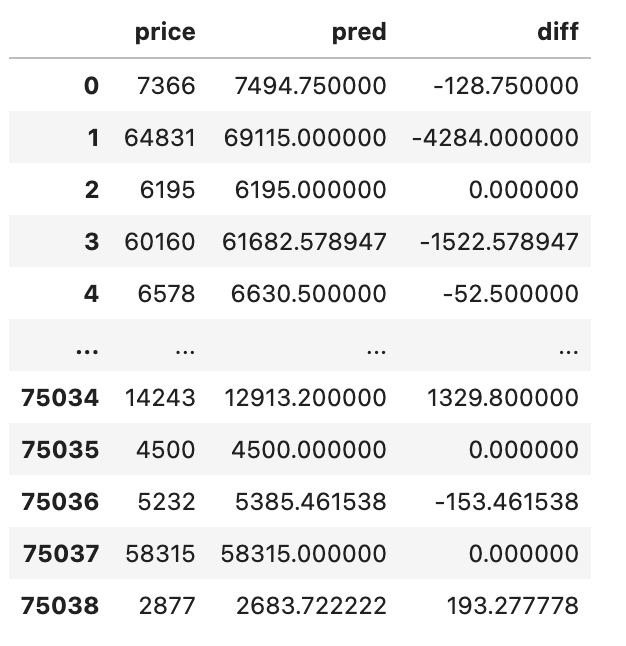

Clearly, there are still errors occuring, but to use a more concrete metric we calculated the RSME and MAE of this regressor.

RMSE:  3003.7394485653826
MAE:  1220.8235647611773

These values are much better than the values we got earlier for the linear regression, and in fact they are almost half of what we had gotten then.

### Bucketing DecisionTree

Moving back to our original DecisionTreeClassifier, we realized that the reason that our accuracies are so low may be due to the fact that there are so many different prices in our datatset and each prediction is being compared to one of these many prices. So, to fix this hurdle, we decided to "bucket" our prices or assign them to ranges so that our classifier had more leeway when being compared to the true values.bucket_price = extra_trees_data.get("price")
len(bucket_price), len(bucket_price.unique())

In [ ]:
bucket_price = extra_trees_data.get("price")
len(bucket_price), len(bucket_price.unique())

In [ ]:
extra_trees_data["bucket_price"] = bucket_price
bins = np.arange(0, 100000, 1000)
extra_trees_data["bucket_price"] = pd.cut(extra_trees_data.bucket_price, bins).apply(lambda x: x.left)

In [ ]:
extra_trees_data = extra_trees_data.dropna()

In [ ]:
X = extra_trees_data.drop('price', axis=1)
X = X.drop('bucket_price', axis=1)
y = extra_trees_data['bucket_price']

feature_names = X.columns
labels = ["".join(item) for item in y.unique().astype(str)]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

We then ran a GridSearch with even more hyperparameters to try to get the highest accuracy we could. 

In [ ]:
param = {
    "criterion": ['gini', 'entropy'],
    "max_depth": [None, 5, 10, 20, 30, 40, 50, 60],
    "max_features": [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
    "min_samples_split":[5, 10, 20, 30, 40, 60, 80],
    "min_impurity_decrease": [0.00001, 0.0001, 0.001, 0.01]
}

grid = GridSearchCV(DecisionTreeClassifier(random_state = 42), param_grid = param, cv = 10, verbose = 1, n_jobs = -1)
grid.fit(X_train, y_train)

The best parameter combination we got was:

    criterion: "entropy"
    max_depth: 30
    max_features: None
    min_impurity_decrease: 1e-05
    min_samples_split: 5

with a best score of 0.7667739447517467

Using these paramters we calculated the new accuracies with the bucketed data. 

In [ ]:
dTree_best = grid.best_estimator_
dTree_best.fit(X_train, y_train)
y_pred_dTree_best = dTree_best.predict(X_test)
print("Training Accuracy:",metrics.accuracy_score(y_train, dTree_best.predict(X_train)))
print("Testing Accuracy:",metrics.accuracy_score(y_test, y_pred_dTree_best))

These accuracies were significantly better than the ones without the bucketed data and the difference between test and train accuracies decreased, meaning that this model generalizes better than the previous one.

In [ ]:
out = X_test
out["prediction"] = y_pred_dTree_best
out["diff"] = out["prediction"] - y_pred_dTree_best
out[out.get("diff") != 0]
out.get("diff").unique()

In [ ]:
data = {"bucket": np.asarray(y_test), 
        "pred": y_pred_dTree_best}
out = pd.DataFrame(data)
out = out[out.get("bucket") != out.get("pred")]
out.get("bucket")
out["diff"] = out["bucket"] - out["pred"]
out

In [ ]:
# on average, each misclassification was off by just over 1 'bucket'
np.mean(out["diff"]) / 1000, np.median(out["diff"]) / 1000

On average each misclassification that our model had was off by just over 1 "bucket". For the purposes of our model, this error is still pretty useful because when predicting a price for a ticket a range gives the user a good estimate of their flight price. 

### RandomForest

Lastly, as a fun extension, we decided to attempt a RandomForest with the hyperparameters we found for our bucketed DecisionTree.

ADD ACCURACY 

# Discussion

### Interpreting the result

OK, you've given us quite a bit of tech informaiton above, now its time to tell us what to pay attention to in all that.  Think clearly about your results, decide on one main point and 2-4 secondary points you want us to understand. Highlight HOW your results support those points.  You probably want 2-5 sentences per point.

### Limitations

Are there any problems with the work?  For instance would more data change the nature of the problem? Would it be good to explore more hyperparams than you had time for?   

### Ethics & Privacy

If your project has obvious potential concerns with ethics or data privacy discuss that here.  Almost every ML project put into production can have ethical implications if you use your imagination. Use your imagination.

Even if you can't come up with an obvious ethical concern that should be addressed, you should know that a large number of ML projects that go into producation have unintended consequences and ethical problems once in production. How will your team address these issues?

Consider a tool to help you address the potential issues such as https://deon.drivendata.org

### Conclusion

Reiterate your main point and in just a few sentences tell us how your results support it. Mention how this work would fit in the background/context of other work in this field if you can. Suggest directions for future work if you want to.

# Footnotes
<a name="lorenznote"></a>1.[^](#lorenz): Lorenz, T. (9 Dec 2021) Birds Aren’t Real, or Are They? Inside a Gen Z Conspiracy Theory. *The New York Times*. https://www.nytimes.com/2021/12/09/technology/birds-arent-real-gen-z-misinformation.html<br> 
<a name="admonishnote"></a>2.[^](#admonish): Also refs should be important to the background, not some randomly chosen vaguely related stuff. Include a web link if possible in refs as above.<br>
<a name="sotanote"></a>3.[^](#sota): Perhaps the current state of the art solution such as you see on [Papers with code](https://paperswithcode.com/sota). Or maybe not SOTA, but rather a standard textbook/Kaggle solution to this kind of problem
